# Notebook 2 : ACP et Clustering

In [14]:
# Chargement des données
import pandas as pd

df = pd.read_csv('donnees_preparees.csv')
df_zone = df['Zone']
X = df.drop(columns=['Zone'])


## Comprendre les relations entre les variables

### Analyse en Composantes Principales (ACP)

In [15]:

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


### Diagramme des Éboulis

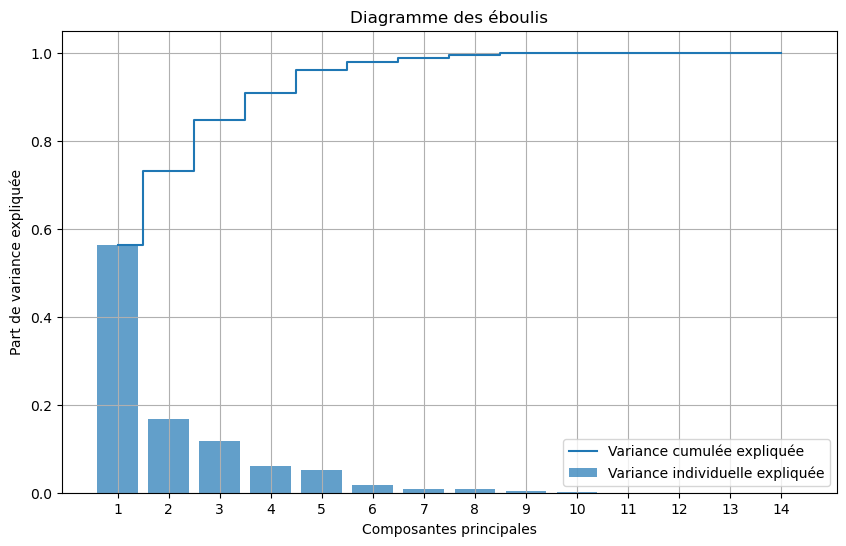

Variance expliquée par PC1 : 56.35%
Variance expliquée par PC2 : 16.72%
Variance cumulée expliquée par les 2 premiers axes : 73.07%


In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# ACP sans limitation du nombre de composantes pour voir la variance expliquée par chacune
pca_full = PCA()
pca_full.fit(X)
explained_variance = pca_full.explained_variance_ratio_

# Diagramme
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center',
        label='Variance individuelle expliquée')
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid',
         label='Variance cumulée expliquée')
plt.ylabel('Part de variance expliquée')
plt.xlabel('Composantes principales')
plt.title('Diagramme des éboulis')
plt.legend(loc='best')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid()
plt.show()

# Pourcentage de variance pour les 2 premiers axes
print(f"Variance expliquée par PC1 : {explained_variance[0]*100:.2f}%")
print(f"Variance expliquée par PC2 : {explained_variance[1]*100:.2f}%")
print(f"Variance cumulée expliquée par les 2 premiers axes : {(explained_variance[0] + explained_variance[1])*100:.2f}%")

### Cercle des corrélations

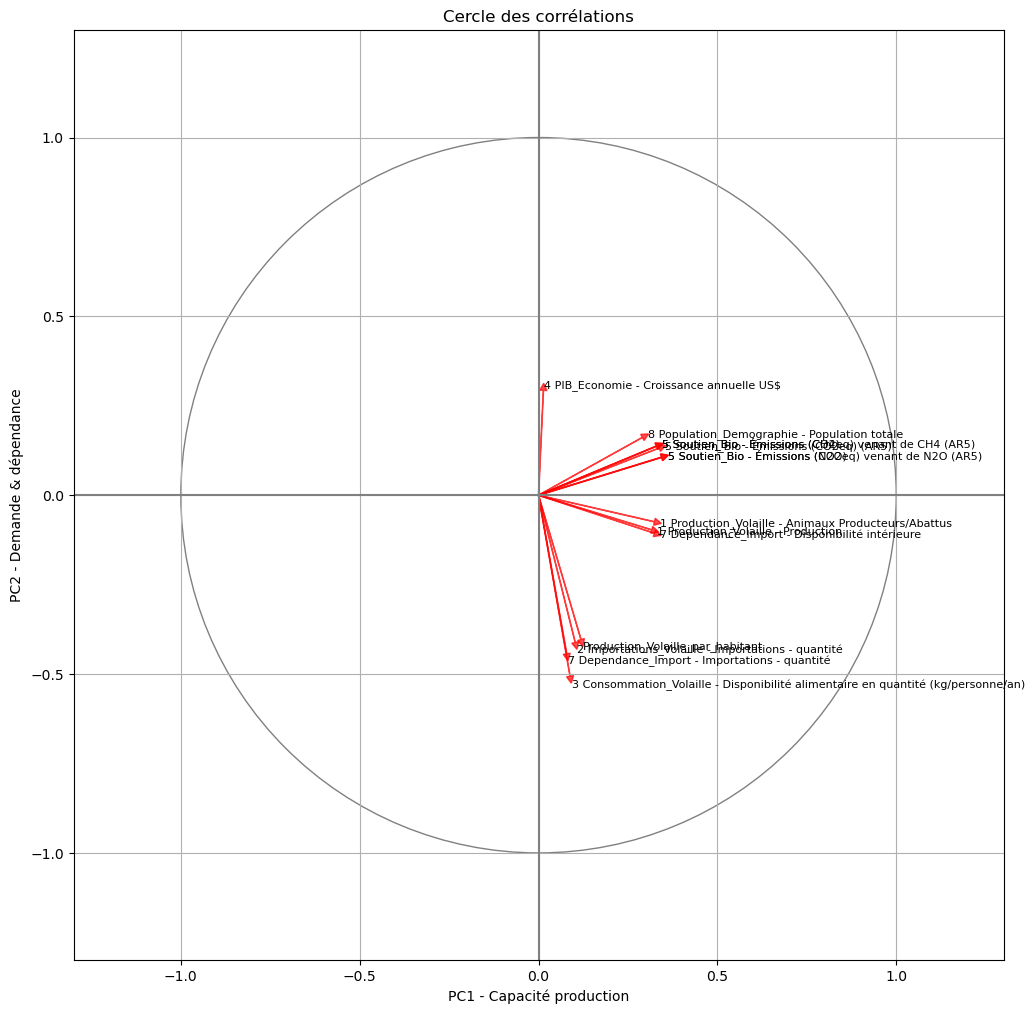

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 40))
circle = plt.Circle((0, 0), 1, color='grey', fill=False)
ax.add_artist(circle)

pcs = pca.components_

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    plt.arrow(0, 0, x, y, color='red', alpha=0.7, head_width=0.02, head_length=0.02)
    
    plt.text(x * 1.05, y * 1.05, X.columns[i], fontsize=8, ha='left', va='center')

plt.axhline(0, color='grey')
plt.axvline(0, color='grey')
plt.xlim(-1.3, 1.3)
plt.ylim(-1.3, 1.3)
plt.xlabel('PC1 - Capacité production')
plt.ylabel('PC2 - Demande & dépendance')
plt.title('Cercle des corrélations')
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [18]:
# Récupération des composantes
components = pca.components_

# Création du tableau de corrélations variables vs composantes
correlation_df = pd.DataFrame(components.T,
                               index=X.columns,
                               columns=["PC1 - Capacité production", "PC2 - Demande & dépendance"])

# Afficher les valeurs triées selon l'importance dans PC1
correlation_df = correlation_df.sort_values("PC1 - Capacité production", ascending=False)

print("Cercle des corrélations (variables vs composantes principales) :")
display(correlation_df)

Cercle des corrélations (variables vs composantes principales) :


,PC1 - Capacité production,PC2 - Demande & dépendance
5 Soutien_Bio - Émissions (CO2eq) venant de N2O (AR5),0.343855,0.106062
5 Soutien_Bio - Émissions (N2O),0.343855,0.106062
5 Soutien_Bio - Émissions (CO2eq) (AR5),0.337107,0.131904
5 Soutien_Bio - Émissions (CH4),0.329399,0.137108
5 Soutien_Bio - Émissions (CO2eq) venant de CH4 (AR5),0.329399,0.137108
1 Production_Volaille - Animaux Producteurs/Abattus,0.323945,-0.074233
7 Dependance_Import - Disponibilité intérieure,0.323800,-0.106155
1 Production_Volaille - Production,0.316276,-0.096693
8 Population_Demographie - Population totale,0.290308,0.161554
Production_Volaille_par_habitant,0.118722,-0.403399


### Projection des pays dans le plan ACP

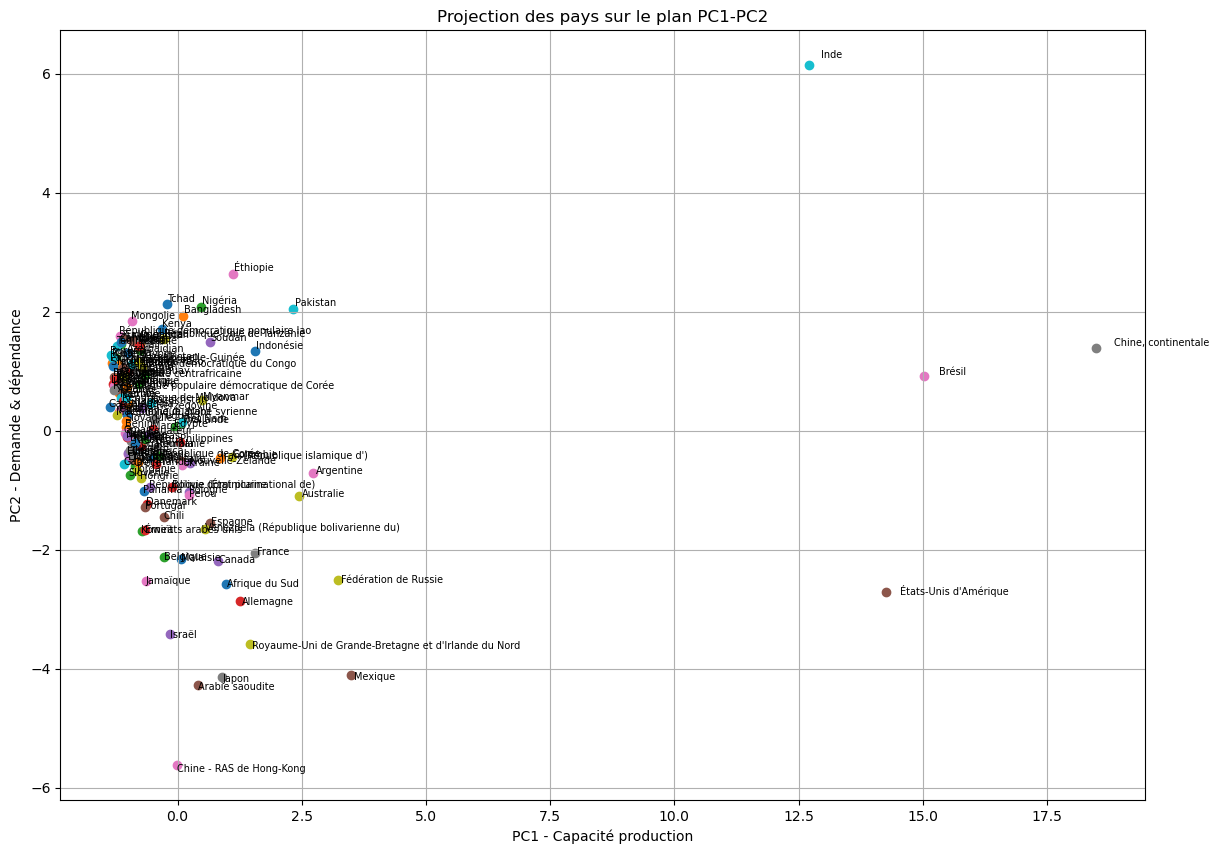

In [19]:

plt.figure(figsize=(14, 10))
for i, (x, y) in enumerate(X_pca):
    plt.scatter(x, y)
    plt.text(x*1.02, y*1.02, df_zone.iloc[i], fontsize=7)
plt.title('Projection des pays sur le plan PC1-PC2')
plt.xlabel('PC1 - Capacité production')
plt.ylabel('PC2 - Demande & dépendance')
plt.grid()
plt.show()


## Réduire la dimension pour faciliter le clustering

### Classification Ascendante Hiérarchique (CAH)

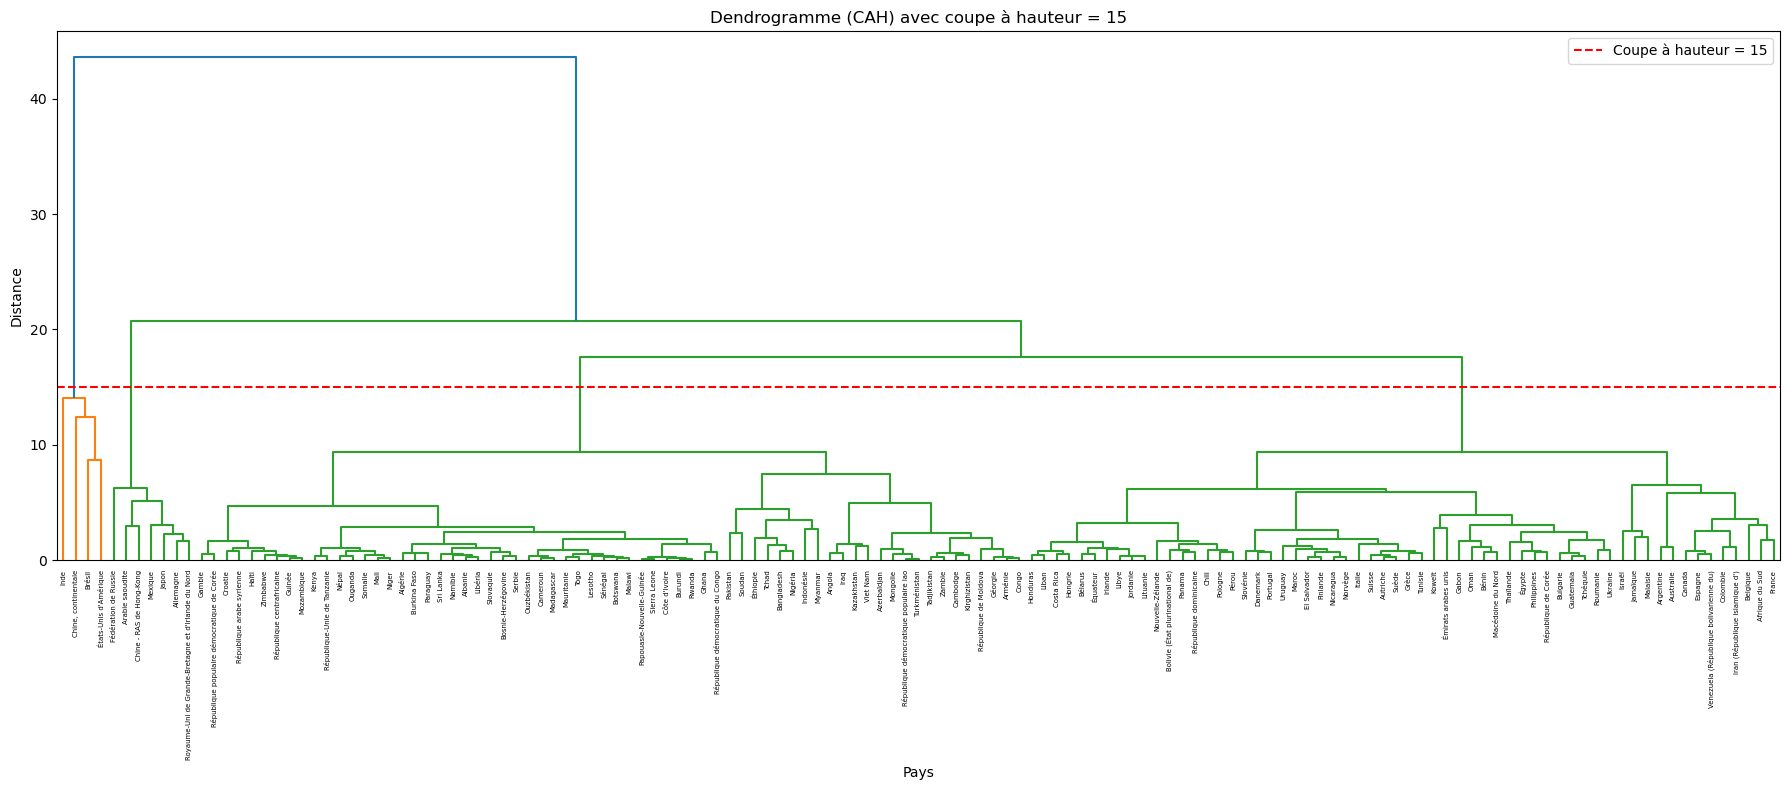

In [20]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import pandas as pd

# ---- Données ----
# X = tes données (numpy array ou DataFrame)
# df_zone = les étiquettes (par ex. noms de pays)

# ---- Étape 1 : Calcul du linkage ----
linked = linkage(X, method='ward')

# ---- Étape 2 : Définir la hauteur de coupe ----
cut_height = 15  # 👈 ici tu règles ta hauteur manuellement

# ---- Étape 3 : Création des clusters selon la distance ----
clusters = fcluster(linked, cut_height, criterion='distance')

# ---- Étape 4 : Affichage du dendrogramme ----
plt.figure(figsize=(18, 8))
dendrogram(linked, labels=df_zone.values, leaf_rotation=90)
plt.axhline(y=cut_height, color='red', linestyle='--',
            label=f'Coupe à hauteur = {cut_height}')
plt.title(f'Dendrogramme (CAH) avec coupe à hauteur = {cut_height}')
plt.xlabel('Pays')
plt.ylabel('Distance')
plt.legend()
plt.tight_layout()
plt.show()


### Clustering par K-means

C:\Users\sebas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\sebas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\sebas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\sebas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

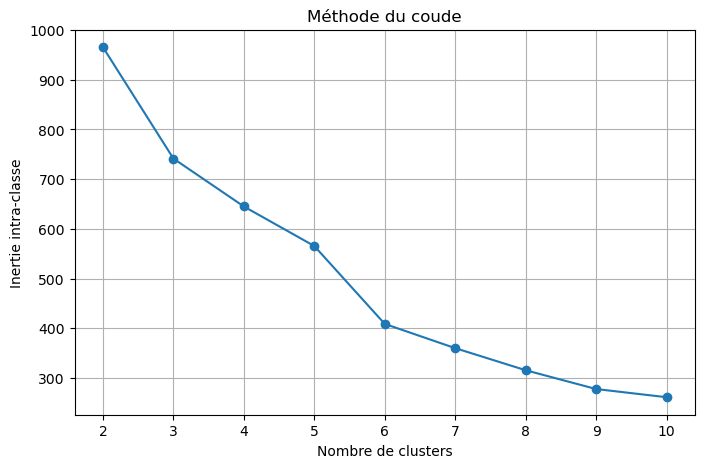

In [21]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Méthode du coude
inertias = []
range_n = range(2, 11)
for k in range_n:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range_n, inertias, marker='o')
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie intra-classe')
plt.grid()
plt.show()

C:\Users\sebas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\sebas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\sebas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\sebas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

,k,Silhouette
0,2,0.82
1,3,0.55
2,4,0.55
3,5,0.55
4,6,0.32
5,7,0.24
6,8,0.25
7,9,0.24
8,10,0.23


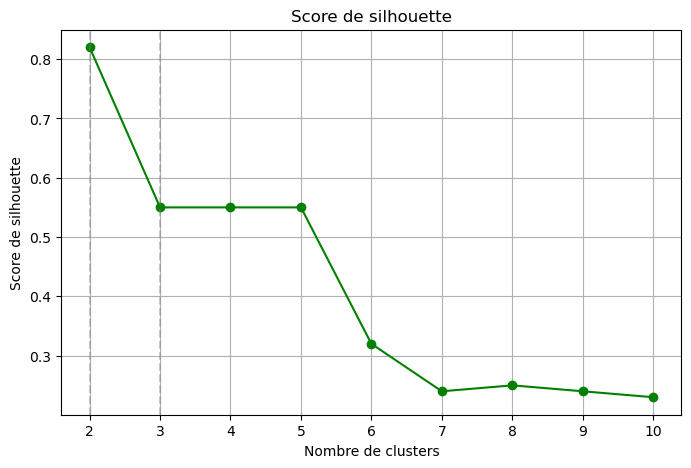

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt

# 1. Calcul des scores silhouette
results = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    score = silhouette_score(X, kmeans.labels_)
    results.append({"k": k, "Silhouette": round(score, 2)})

# 2. Affichage du tableau
df_silhouette = pd.DataFrame(results)
display(df_silhouette)  # ou print(df_silhouette) si hors Jupyter

# 3. Graphique
plt.figure(figsize=(8, 5))
plt.plot(df_silhouette["k"], df_silhouette["Silhouette"], marker='o', linestyle='-', color='green')
plt.title("Score de silhouette")
plt.xlabel("Nombre de clusters")
plt.ylabel("Score de silhouette")
plt.grid(True)
plt.xticks(df_silhouette["k"])
plt.axvline(x=2, color='grey', linestyle='--', alpha=0.4)
plt.axvline(x=3, color='grey', linestyle='--', alpha=0.4)
plt.show()

### Visualisation des clusters retenus

C:\Users\sebas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


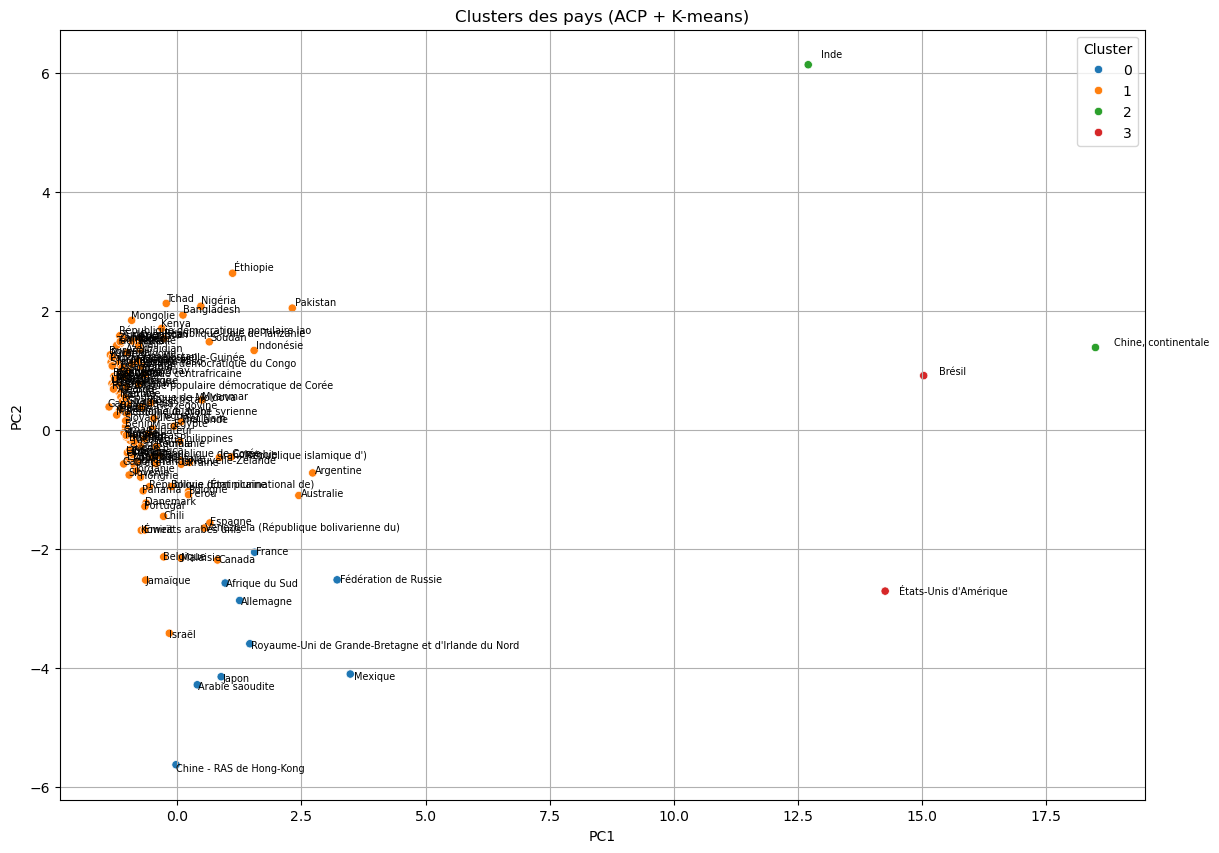

In [23]:

# Application du K-means avec k=4 (ou tout autre choisi)
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
df['Cluster'] = kmeans.labels_

# Visualisation des clusters
import seaborn as sns

plt.figure(figsize=(14,10))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['Cluster'], palette='tab10')
for i, txt in enumerate(df_zone):
    plt.text(X_pca[i,0]*1.02, X_pca[i,1]*1.02, txt, fontsize=7)
plt.title('Clusters des pays (ACP + K-means)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.grid()
plt.show()


In [24]:
# Calcul et affichage des centroïdes des clusters

# Utilisation des données normalisées 'X' pour le calcul
X_with_clusters = X.copy()
X_with_clusters['Cluster'] = df['Cluster']

# Calcul des centroïdes en faisant la moyenne par cluster
centroids_scaled = X_with_clusters.groupby('Cluster').mean()

print("Centroïdes des clusters (sur données normalisées) :")

# Export en CSV
centroids_scaled.to_csv('centroids_clusters.csv')

# Affichage du tableau
display(centroids_scaled)

Centroïdes des clusters (sur données normalisées) :


,1 Production_Volaille - Animaux Producteurs/Abattus,1 Production_Volaille - Production,2 Importations_Volaille - Importations - quantité,3 Consommation_Volaille - Disponibilité alimentaire en quantité (kg/personne/an),4 PIB_Economie - Croissance annuelle US$,5 Soutien_Bio - Émissions (CH4),5 Soutien_Bio - Émissions (CO2eq) (AR5),5 Soutien_Bio - Émissions (CO2eq) venant de CH4 (AR5),5 Soutien_Bio - Émissions (CO2eq) venant de N2O (AR5),5 Soutien_Bio - Émissions (N2O),7 Dependance_Import - Disponibilité intérieure,7 Dependance_Import - Importations - quantité,8 Population_Demographie - Population totale,Production_Volaille_par_habitant
Cluster,,,,,,,,,,,,,,
0,0.398787,0.372801,3.032718,0.962099,-0.824568,0.176597,0.178525,0.176597,0.174635,0.174635,0.616027,3.206929,0.168378,0.335303
1,-0.187089,-0.185226,-0.238612,-0.094375,0.049800,-0.182052,-0.183834,-0.182052,-0.179124,-0.179124,-0.200088,-0.242184,-0.159146,-0.066218
2,4.000266,3.113226,1.471890,-0.683182,1.341265,5.675083,5.751705,5.675083,5.676645,5.676645,4.194963,0.795263,7.837959,-0.603939
3,5.804718,6.693198,-0.325174,2.205005,-0.718311,4.817443,4.842630,4.817443,4.643165,4.643165,5.438375,-0.211041,1.271381,3.200620


### Split cluster 1

C:\Users\sebas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


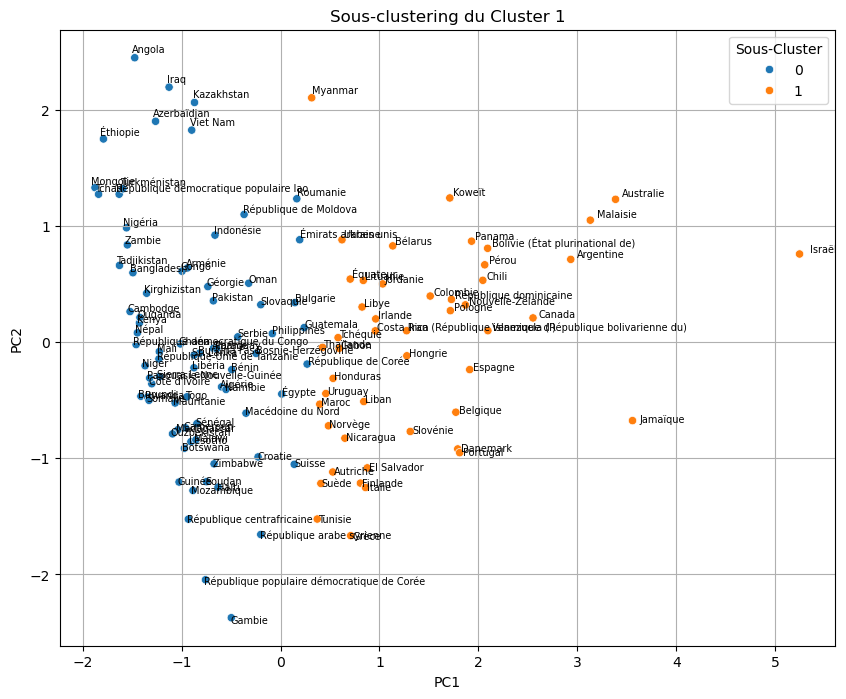

In [25]:
# Pays du Cluster 1
cluster_main = 1 
cluster_main_df = df[df['Cluster'] == cluster_main].copy()
X_cluster_main = X[df['Cluster'] == cluster_main]
df_zone_cluster_main = cluster_main_df['Zone']

# Mini-ACP sur ce cluster
pca_cluster_main = PCA(n_components=2)
X_pca_cluster_main = pca_cluster_main.fit_transform(X_cluster_main)

# K-means sur ce cluster pour k=2
kmeans_cluster_main = KMeans(n_clusters=2, random_state=0).fit(X_cluster_main)
cluster_main_df['SubCluster'] = kmeans_cluster_main.labels_

# Visualisation
plt.figure(figsize=(10,8))
sns.scatterplot(x=X_pca_cluster_main[:,0], y=X_pca_cluster_main[:,1], hue=cluster_main_df['SubCluster'], palette='tab10')
for i, txt in enumerate(df_zone_cluster_main):
    plt.text(X_pca_cluster_main[i,0]*1.02, X_pca_cluster_main[i,1]*1.02, txt, fontsize=7)
plt.title(f'Sous-clustering du Cluster {cluster_main}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Sous-Cluster')
plt.grid()
plt.show()



In [27]:
import pandas as pd

# Vérifie que ces deux colonnes existent
assert "Zone" in df.columns, "'Zone' n'existe pas dans df"
assert "Cluster" in df.columns, "'Cluster' n'existe pas dans df"

# Création du fichier Excel avec un onglet par cluster
with pd.ExcelWriter("pays_par_cluster.xlsx") as writer:
    for cluster_id in sorted(df["Cluster"].unique()):
        df_cluster = df[df["Cluster"] == cluster_id][["Zone"]].sort_values("Zone")
        df_cluster.to_excel(writer, sheet_name=f"Cluster_{cluster_id}", index=False)
